In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import os
import h5py
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load embeddings and align classes

In [3]:
embeddings = h5py.File('embeddings.h5', 'r')

def printname(name):
    print(name)
embeddings.visit(printname)

irmas
irmas/openl3
irmas/openl3/features
irmas/openl3/keys
irmas/vggish
irmas/vggish/features
irmas/vggish/keys
openmic
openmic/openl3
openmic/openl3/features
openmic/openl3/keys
openmic/vggish
openmic/vggish/features
openmic/vggish/keys


In [4]:
with open('class-map-10.json', 'r') as f:
    class_map = json.load(f)
    
class_map

{'cello': 3,
 'clarinet': 4,
 'flute': 7,
 'guitar': 8,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'trumpet': 16,
 'violin': 18,
 'voice': 19}

In [5]:
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

# irmas->irmas

In [6]:
# irmas: openl3 embedding
feature = np.array(embeddings['irmas']['openl3']['features'])
keys_ori = np.array(embeddings['irmas']['openl3']['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

(167625, 512) (167625,)
(6705,)


In [7]:
key_clip

array([b'001__[gel][dru][pop_roc]0829__1',
       b'001__[gel][dru][pop_roc]0829__2',
       b'001__[gel][dru][pop_roc]0829__3', ..., b'[voi][pop_roc]2548__1',
       b'[voi][pop_roc]2548__2', b'[voi][pop_roc]2548__3'], dtype=object)

In [8]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 512) (6705,)


In [9]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

In [10]:
# These loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
# Finally, cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [11]:
keys = np.array([str(k, 'utf-8') for k in key_clip])
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [12]:
# Finally, we use the split indices to partition the features, labels, and masks
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

# Print out the sliced shapes as a sanity check
print(X_train.shape)
print(X_test.shape)

(3910, 512)
(2795, 512)


In [13]:
# use a dictionary to include the classifier for each instrument trained on IRMAS dataset based on Openl3 embedding
models_openl3_irmas = dict()  
# use a dictionary to record the classification result for each instrument
result_openl3_irmas_irmas = dict()  

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_train_inst = Y_true_train==instrument
    Y_true_test_inst = Y_true_test==instrument
    
    # initialize and fit a logistic regression model
    clf = LogisticRegression(random_state=0, penalty='l1', solver='liblinear')
    clf.fit(X_train, Y_true_train_inst)

    # predict
    Y_pred_test = clf.predict(X_test)
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test))
    
    # Store the classifier in the model dictionary
    models_openl3_irmas[instrument] = clf
    
    #########################  record result of each split  ###############################
    # extract P,R,F values from classification_report
    lineSep = 54 ; dist = 10; 
    Pos_firstNum = classification_report(Y_true_test_inst, Y_pred_test).find('\n') + 21 
    result_openl3_irmas_irmas[instrument] = np.array([float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+lineSep:Pos_firstNum+4+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*1+lineSep:Pos_firstNum+4+dist*1+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*2+lineSep:Pos_firstNum+4+dist*2+lineSep])])

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       1.00      0.98      0.99      2765
        True       0.23      0.67      0.34        30

    accuracy                           0.97      2795
   macro avg       0.61      0.82      0.66      2795
weighted avg       0.99      0.97      0.98      2795

----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       1.00      0.86      0.92      2744
        True       0.11      0.88      0.19        51

    accuracy                           0.86      2795
   macro avg       0.55      0.87      0.56      2795
weighted avg       0.98      0.86      0.91      2795

----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.86      1.00      0.93      2388
        True       0.95      0.05      

In [14]:
result_openl3_irmas_irmas

{'cello': array([0.23, 0.67, 0.34]),
 'clarinet': array([0.11, 0.88, 0.19]),
 'flute': array([0.95, 0.05, 0.1 ]),
 'guitar': array([0.7 , 0.59, 0.64]),
 'organ': array([0.02, 1.  , 0.03]),
 'piano': array([0.98, 0.64, 0.77]),
 'saxophone': array([0.43, 0.15, 0.22]),
 'trumpet': array([0.83, 0.02, 0.04]),
 'violin': array([0.18, 0.77, 0.3 ]),
 'voice': array([0.79, 0.93, 0.85])}

In [15]:
# result averaged over all instruments
PRF_openl3_irmas_irmas = []
for instrument in class_map:
    PRF_openl3_irmas_irmas.append(result_openl3_irmas_irmas[instrument])
PRF_openl3_irmas_irmas = np.array(PRF_openl3_irmas_irmas)
np.mean(PRF_openl3_irmas_irmas,axis=0)

array([0.522, 0.57 , 0.348])

# openmic->openmic

In [16]:
# openmic: openl3 embedding
feature = np.array(embeddings['openmic']['openl3']['features'])
keys = np.array(embeddings['openmic']['openl3']['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)
key_clip.shape

(1900000, 512) (1900000,)


(20000,)

In [17]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

key_clip = np.array([str(k, 'utf-8') for k in key_clip])
key_clip

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 512) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype='<U15')

In [18]:
# key-label map using the information from the dataset source
data_root = '/import/c4dm-datasets/openmic-2018/openmic-2018/'

np_load_old = np.load   # save np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True,**k)   # modify the default parameters of np.load

Ytrue = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_true']
Ymask = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_mask']
sample_key = np.load(os.path.join(data_root, 'openmic-2018.npz'))['sample_key']

np.load = np_load_old   # restore np.load for future normal usage
del(np_load_old)

print(Ytrue.shape, Ymask.shape, sample_key.shape)

(20000, 20) (20000, 20) (20000,)


In [19]:
Y_true = []
Y_mask = []

for key in tqdm(key_clip):
    Y_true.append(Ytrue[sample_key==key])
    Y_mask.append(Ymask[sample_key==key])
    
Y_true = np.squeeze(np.array(Y_true))
Y_mask = np.squeeze(np.array(Y_mask))

X = feature_clip
del(feature_clip)

print(X.shape, Y_true.shape, Y_mask.shape)

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 512) (20000, 20) (20000, 20)


In [20]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [21]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [22]:
X_train = X[idx_train]
X_test = X[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

print(X_train.shape); print(X_test.shape)

(14915, 512)
(5085, 512)


In [23]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
# use a dictionary to include the classifier for each instrument trained on Openmic dataset based on Openl3 embedding
models_openl3_openmic = dict()  
# use a dictionary to record the classification result for each instrument
result_openl3_openmic_openmic = dict()  

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_map:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst = X_train[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # initialize and fit a logistic regression model
    clf = LogisticRegression(random_state=0, penalty='l1', solver='liblinear')
    clf.fit(X_train_inst, Y_true_train_inst)

    # predict
    Y_pred_test = clf.predict(X_test_inst)
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test))
    
    # Store the classifier in the model dictionary
    models_openl3_openmic[instrument] = clf
    
    #########################  record result of each split  ###############################
    # extract P,R,F values from classification_report
    lineSep = 54 ; dist = 10; 
    Pos_firstNum = classification_report(Y_true_test_inst, Y_pred_test).find('\n') + 21 
    result_openl3_openmic_openmic[instrument] = np.array([float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+lineSep:Pos_firstNum+4+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*1+lineSep:Pos_firstNum+4+dist*1+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*2+lineSep:Pos_firstNum+4+dist*2+lineSep])])

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.78      0.84      0.81       259
        True       0.80      0.73      0.76       226

    accuracy                           0.79       485
   macro avg       0.79      0.78      0.78       485
weighted avg       0.79      0.79      0.78       485

----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.84      0.87      0.86       503
        True       0.46      0.39      0.42       137

    accuracy                           0.77       640
   macro avg       0.65      0.63      0.64       640
weighted avg       0.76      0.77      0.76       640

----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.81      0.80      0.81       387
        True       0.57      0.59      

In [24]:
result_openl3_openmic_openmic

{'cello': array([0.8 , 0.73, 0.76]),
 'clarinet': array([0.46, 0.39, 0.42]),
 'flute': array([0.57, 0.59, 0.58]),
 'guitar': array([0.97, 0.97, 0.97]),
 'organ': array([0.57, 0.51, 0.54]),
 'piano': array([0.95, 0.98, 0.96]),
 'saxophone': array([0.74, 0.78, 0.76]),
 'trumpet': array([0.76, 0.7 , 0.73]),
 'violin': array([0.87, 0.88, 0.87]),
 'voice': array([0.94, 0.9 , 0.92])}

In [25]:
# result averaged over all instruments
PRF_openl3_openmic_openmic = []
for instrument in class_map:
    PRF_openl3_openmic_openmic.append(result_openl3_openmic_openmic[instrument])
PRF_openl3_openmic_openmic = np.array(PRF_openl3_openmic_openmic)
np.mean(PRF_openl3_openmic_openmic,axis=0)

array([0.763, 0.743, 0.751])

# irmas->openmic

In [26]:
# use a dictionary to record the classification result for each instrument
result_openl3_irmas_openmic = dict()  

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations 
    # This is what the mask arrays are for
    test_inst = Y_mask_test[:, inst_num]

    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # Finally, we'll evaluate the classifier trained on IRMAS dataset to the Openmic test data
    Y_pred_test =  models_openl3_irmas[instrument].predict(X_test_inst)
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test))
    
    #########################  record result for each instrument  ###############################
    # extract P,R,F values from classification_report
    lineSep = 54 ; dist = 10; 
    Pos_firstNum = classification_report(Y_true_test_inst, Y_pred_test).find('\n') + 21 
    result_openl3_irmas_openmic[instrument] = np.array([float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+lineSep:Pos_firstNum+4+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*1+lineSep:Pos_firstNum+4+dist*1+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*2+lineSep:Pos_firstNum+4+dist*2+lineSep])])

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.54      0.94      0.69       259
        True       0.54      0.08      0.15       226

    accuracy                           0.54       485
   macro avg       0.54      0.51      0.42       485
weighted avg       0.54      0.54      0.43       485

----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.79      0.97      0.87       503
        True       0.26      0.04      0.06       137

    accuracy                           0.77       640
   macro avg       0.53      0.50      0.47       640
weighted avg       0.68      0.77      0.70       640

----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.69      1.00      0.82       387
        True       0.00      0.00      

In [27]:
result_openl3_irmas_openmic

{'cello': array([0.54, 0.08, 0.15]),
 'clarinet': array([0.26, 0.04, 0.06]),
 'flute': array([0., 0., 0.]),
 'guitar': array([0.97, 0.66, 0.78]),
 'organ': array([0.36, 0.4 , 0.38]),
 'piano': array([0.99, 0.42, 0.59]),
 'saxophone': array([0.71, 0.02, 0.03]),
 'trumpet': array([0.56, 0.02, 0.03]),
 'violin': array([0.8 , 0.62, 0.7 ]),
 'voice': array([0.97, 0.65, 0.78])}

In [28]:
# result averaged over all instruments
PRF_openl3_irmas_openmic = []
for instrument in class_map:
    PRF_openl3_irmas_openmic.append(result_openl3_irmas_openmic[instrument])
PRF_openl3_irmas_openmic = np.array(PRF_openl3_irmas_openmic)
np.mean(PRF_openl3_irmas_openmic,axis=0)

array([0.616, 0.291, 0.35 ])

# openmic->irmas

In [29]:
# irmas: openl3 embedding
feature = np.array(embeddings['irmas']['openl3']['features'])
keys_ori = np.array(embeddings['irmas']['openl3']['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(167625, 512) (167625,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 512) (6705,)


In [30]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [31]:
keys = np.array([str(k, 'utf-8') for k in key_clip])
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [32]:
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

print(X_train.shape)
print(X_test.shape)

(3910, 512)
(2795, 512)


In [33]:
# use a dictionary to record the classification result for each instrument
result_openl3_openmic_irmas = dict()  

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_test_inst = Y_true_test==instrument

    # Finally, we'll evaluate the classifier trained on IRMAS dataset to the Openmic test data
    Y_pred_test =  models_openl3_openmic[instrument].predict(X_test)
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test))
    
    #########################  record result for each instrument  ###############################
    # extract P,R,F values from classification_report
    lineSep = 54 ; dist = 10; 
    Pos_firstNum = classification_report(Y_true_test_inst, Y_pred_test).find('\n') + 21 
    result_openl3_openmic_irmas[instrument] = np.array([float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+lineSep:Pos_firstNum+4+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*1+lineSep:Pos_firstNum+4+dist*1+lineSep]),\
              float(classification_report(Y_true_test_inst, Y_pred_test)[Pos_firstNum+dist*2+lineSep:Pos_firstNum+4+dist*2+lineSep])])

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       1.00      0.88      0.93      2765
        True       0.07      0.80      0.12        30

    accuracy                           0.88      2795
   macro avg       0.53      0.84      0.53      2795
weighted avg       0.99      0.88      0.93      2795

----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       1.00      0.46      0.63      2744
        True       0.03      0.92      0.06        51

    accuracy                           0.47      2795
   macro avg       0.51      0.69      0.34      2795
weighted avg       0.98      0.47      0.62      2795

----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.94      0.65      0.77      2388
        True       0.27      0.75      

In [34]:
result_openl3_openmic_irmas

{'cello': array([0.07, 0.8 , 0.12]),
 'clarinet': array([0.03, 0.92, 0.06]),
 'flute': array([0.27, 0.75, 0.4 ]),
 'guitar': array([0.27, 0.95, 0.42]),
 'organ': array([0., 0., 0.]),
 'piano': array([0.43, 0.92, 0.59]),
 'saxophone': array([0.25, 0.85, 0.38]),
 'trumpet': array([0.28, 0.94, 0.44]),
 'violin': array([0.12, 0.89, 0.22]),
 'voice': array([0.18, 1.  , 0.31])}

In [35]:
# result averaged over all instruments
PRF_openl3_openmic_irmas = []
for instrument in class_map:
    PRF_openl3_openmic_irmas.append(result_openl3_openmic_irmas[instrument])
PRF_openl3_openmic_irmas = np.array(PRF_openl3_openmic_irmas)
np.mean(PRF_openl3_openmic_irmas,axis=0)

array([0.19 , 0.802, 0.294])

# Plot result for each instrument

In [36]:
# The mean PRF for each case:
print('PRF of Openl3 averaged over all instruments for each case:')
print('irmas->irmas:{}'.format(np.mean(PRF_openl3_irmas_irmas,axis=0)))
print('openmic->openmic:{}'.format(np.mean(PRF_openl3_openmic_openmic,axis=0)))
print('irmas->openmic:{}'.format(np.mean(PRF_openl3_irmas_openmic,axis=0)))
print('openmic->irmas:{}'.format(np.mean(PRF_openl3_openmic_irmas,axis=0)))

PRF of Openl3 averaged over all instruments for each case:
irmas->irmas:[0.522 0.57  0.348]
openmic->openmic:[0.763 0.743 0.751]
irmas->openmic:[0.616 0.291 0.35 ]
openmic->irmas:[0.19  0.802 0.294]


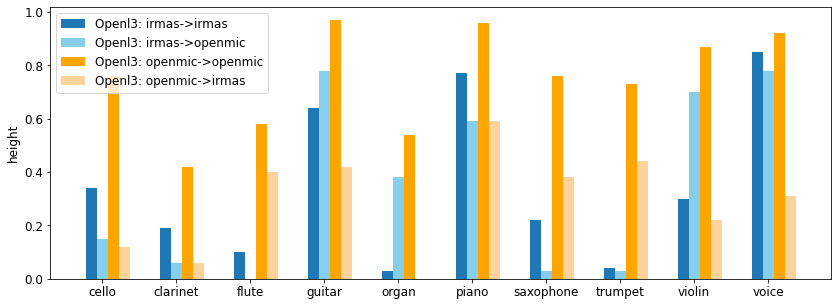

In [37]:
plt.rcParams.update({'font.size':12})
plt.figure(figsize=(14,5))
 
barWidth = 0.15  # width of the bars
 
# Set bars
bars1 = [result_openl3_irmas_irmas[inst][-1] for inst in class_align]
bars2 = [result_openl3_irmas_openmic[inst][-1] for inst in class_align]
bars3 = [result_openl3_openmic_openmic[inst][-1] for inst in class_align]
bars4 = [result_openl3_openmic_irmas[inst][-1] for inst in class_align]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
r4 = [x + 3*barWidth for x in r1]
 
# Create bars
plt.bar(r1, bars1, width = barWidth, capsize=7, label='Openl3: irmas->irmas')
plt.bar(r2, bars2, width = barWidth, color='skyblue', capsize=7, label='Openl3: irmas->openmic')
plt.bar(r3, bars3, width = barWidth, color='#FFA500', capsize=7, label='Openl3: openmic->openmic')
plt.bar(r4, bars4, width = barWidth, color='#FFD39B', capsize=7, label='Openl3: openmic->irmas')
 
plt.xticks([r + barWidth for r in range(len(bars1))], [inst for inst in class_align])
plt.ylabel('height'); plt.legend()